In [107]:
import json
import geopandas as gpd
from multimodal_network import *

study_area_filename = 'shapes/study_area/study_area_buffer.shp'
study_area = gpd.read_file(study_area_filename).to_crs('EPSG:4326')
study_area_polygon = study_area.iloc[0]['geometry']
network = MultiModalNetwork.from_polygon(study_area_polygon, speeds={'walk': 1.4, 'bike':2.16}, directed={'walk': True, 'bike': True})
#network.save_shortest_paths_all_layers()

transfer
speeds
graphs
Creating walk graph...
True
Creating bike graph...
True


In [31]:
from tqdm.notebook import tqdm
def write_paths(replica_filename):
    print('Converting: ' + replica_filename)
    with open(replica_filename) as file:
        replica = json.load(file)
    for i, trip in zip(tqdm(range(len(replica['trips']))), replica['trips']):
        #print(trip['scooter']['battery_level_dropoff'])
        if trip['ride_duration'] == np.inf:
            replica['trips'].remove(trip)
        else:
            if trip['pickup_time'] != None:
                #print('Walk from {} to {}'.format(trip['origin'], trip['pickup_node']))
                try:
                    path = network.shortest_path_edges(trip['origin'], trip['pickup_node'], layer='walk')
                    trip['walk'] = path
                except:
                    replica['trips'].remove(trip)

                #print('Ride from {} to {}'.format(trip['pickup_node'], trip['destination']))
                try:
                    path = network.shortest_path_edges(trip['pickup_node'], trip['destination'], layer='bike')
                    trip['ride'] = path
                except:
                    try:
                        replica['trips'].remove(trip)
                    except:
                        pass
    with open(replica_filename, 'w') as file:
        json.dump(replica, file)

for i in range(2):
    write_paths('visualization/data/stkde_nhpp_{}.json'.format(i))
    for m in range(2, 4):
        write_paths('visualization/data/stkde_nhpp_{}_HRP_{}.0.json'.format(i, m))

Converting: visualization/data/stkde_nhpp_0.json



Converting: visualization/data/stkde_nhpp_0_HRP_2.0.json



Converting: visualization/data/stkde_nhpp_0_HRP_3.0.json



Converting: visualization/data/stkde_nhpp_1.json



Converting: visualization/data/stkde_nhpp_1_HRP_2.0.json



Converting: visualization/data/stkde_nhpp_1_HRP_3.0.json


In [145]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')


def load_replicas_to_df(results_dir = 'visualization/data', replicas=20, methods=['_HRP_3.0', '', '_HRP_2.0'], days=1):
    replicas_stats = []
    for i in range(replicas):
        replica_dict = {'replica': i}
        for method in methods:
            replica_dir = results_dir + '/stkde_nhpp_{}{}.json'.format(i, method)
            with open(replica_dir, 'r') as file:
                replica = json.load(file)

            satisfied_requests = sum([not trip['pickup_time'] == None for trip in replica['trips'] if trip['arrival_time']<= 24 * 3600 * days])
            total_requests = len([trip for trip in replica['trips'] if trip['arrival_time'] <= 24 * 3600 * days])
            expenses = np.array([float(trip['pricing']) for trip in replica['trips'] if trip['pricing']!=None])
            total_expense = expenses.sum()
            n_pricing = len(expenses)
            replica_dict['satisfied_requests' + method] = satisfied_requests
            replica_dict['total_requests' + method] = total_requests
            replica_dict['expense' + method] = total_expense
            replica_dict['n_pricing' + method] = n_pricing
        replicas_stats.append(replica_dict)
    return pd.DataFrame(replicas_stats)
#'_HRP_1.0', '_HRP_2.0', '_HRP_3.0'
methods = ['', '_HRP_1.0', '_HRP_2.0', '_HRP_3.0', '_random_3.0']
replicas_df = load_replicas_to_df(replicas=2, days=7, methods=methods)
for method in methods:
    replicas_df['service_level' + method] = replicas_df['satisfied_requests' + method] / replicas_df['total_requests' + method] 

In [146]:
replicas_df[['service_level' + method for method in methods]].mean()

service_level               0.811102
service_level_HRP_1.0       0.825276
service_level_HRP_2.0       0.835538
service_level_HRP_3.0       0.836234
service_level_random_3.0    0.840759
dtype: float64

In [147]:
replicas_df[['service_level' + method for method in methods]].std()

service_level               0.005087
service_level_HRP_1.0       0.002282
service_level_HRP_2.0       0.001808
service_level_HRP_3.0       0.001563
service_level_random_3.0    0.004277
dtype: float64

In [148]:
for method in methods:
    replicas_df['DUR' + method] = ((replicas_df['total_requests'] - replicas_df['satisfied_requests']) - (replicas_df['total_requests'] - replicas_df['satisfied_requests' + method]))\
                                / (replicas_df['total_requests'] - replicas_df['satisfied_requests'])

In [149]:
replicas_df[['DUR' + method for method in methods]].mean()

DUR               0.000000
DUR_HRP_1.0       0.074862
DUR_HRP_2.0       0.129175
DUR_HRP_3.0       0.132841
DUR_random_3.0    0.156997
dtype: float64

In [150]:
replicas_df

,replica,satisfied_requests,total_requests,expense,n_pricing,satisfied_requests_HRP_1.0,total_requests_HRP_1.0,expense_HRP_1.0,n_pricing_HRP_1.0,satisfied_requests_HRP_2.0,...,service_level,service_level_HRP_1.0,service_level_HRP_2.0,service_level_HRP_3.0,service_level_random_3.0,DUR,DUR_HRP_1.0,DUR_HRP_2.0,DUR_HRP_3.0,DUR_random_3.0
0,0,4648,5756,0.0,0,4741,5756,58.066392,78,4802,...,0.807505,0.823662,0.834260,0.835129,0.837735,0.0,0.083935,0.138989,0.143502,0.157040
1,1,4678,5742,0.0,0,4748,5742,48.206504,69,4805,...,0.814699,0.826890,0.836816,0.837339,0.843783,0.0,0.065789,0.119361,0.122180,0.156955


In [151]:
replicas_df['satisfied_requests_HRP_2.0'] - replicas_df['satisfied_requests']

0    154
1    127
dtype: int64

In [158]:
0.6 * 0.95**(100)

0.0035523175322003985

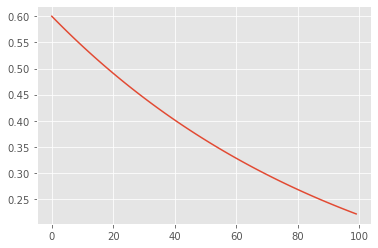

In [171]:
x = np.arange(0, 100)
mu = 0.6 *0.99**(x)
plt.plot(x, mu)